In [1]:
import os
import sys

from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan,atan2,copysign
import numpy as np

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
import scipy
from scipy.stats import norm
import random
import time
import timeit
import math
import localization as lx
import gzip

import util.npose_util as nu
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree

import tensorflow as tf
import joblib
from sklearn.manifold import MDS
import argparse
from functools import partial
from itertools import starmap,repeat,permutations

from pymol import cmd, stored, selector

import GenerateEndpoints as ge
import HelixFit as hf
import FitTransform as ft

import seaborn as sns
import util.RotationMethods as rm

#reference helix for propogation
zero_ih = nu.npose_from_file('util/zero_ih.pdb')
tt = zero_ih.reshape(int(len(zero_ih)/5),5,4)
stub = tt[7:10].reshape(15,4)

np.set_printoptions(precision=2)

%config Completer.use_jedi = False

In [2]:
#load distance maps and endpoints dataset
def load_distance_map(name, dm_file='data/Fits_4H_dm_phi.npz'):
    rr = np.load(dm_file, allow_pickle=True)
    X_train, y_train , featNames = [rr[f] for f in rr.files]
    
    
    return X_train[y_train==name][:,:-4]

# dm_file = 'data/Fits_4H_dm_phi.npz'
# rr = np.load(dm_file, allow_pickle=True)
# X_train, y_train , featNames = [rr[f] for f in rr.files]
# = 'data/4H_dataset/models/'
# cmd.load(f'{model_direc}{y_train[0]}.pdb')
# cmd.save(f'output/test.pdb')

#endpoints for data set 
Fits4H_file = 'data/Fits_4H.csv'
dfRead = pd.read_csv(Fits4H_file)
df1 = ft.prepData_Str(dfRead,rmsd_filter=100)
df2 = ft.EndPoint(df1)
ep = df2.to_numpy()[:,:24].astype(float).reshape((-1,8,3))
X = ep


In [3]:
def index_helix_ep(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    hi = np.array(helices_desired,dtype=int)
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    #alternate example for indexing batch of X 
    #X.reshape((X.shape[0],-1))[:,indexarray]
    
    #select desired endpoints from  batch of endpoints
    return X[np.ix_(np.array(range(ep_in.shape[0])),h_ep[hi].flatten(), np.array(range(ep_in.shape[2])))]
    
def get_midpoint(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    
    ind_ep = index_helix_ep(ep_in, helices_desired=helices_desired, num_helices=4)
    
    #calculate midpoint
    midpoint = ind_ep.sum(axis=1)/np.repeat(ind_ep.shape[1], ind_ep.shape[2])
    
    return midpoint

def get_stubs_from_points(ep_in,index=[0,1,2]):
#def get_stubs_from_n_ca_c(n, ca, c):
    """Modified from Brian's npose code  get_stubs_from_n_ca_c, index references 3 points, to define plane.
    """
    e1 = ep_in[:,index[1]]-ep_in[:,index[0]]
    e1 = np.divide( e1, np.linalg.norm(e1, axis=1)[..., None] )

    e3 = np.cross( e1, ep_in[:,index[2]]-ep_in[:,index[0]], axis=1 )
    e3 = np.divide( e3, np.linalg.norm(e3, axis=1)[..., None] )

    e2 = np.cross( e3, e1, axis=1 )

    stub = np.zeros((len(ep_in), 4, 4))
    stub[...,:3,0] = e1
    stub[...,:3,1] = e2
    stub[...,:3,2] = e3
    stub[...,:3,3] = ep_in[:,index[1]]
    stub[...,3,3] = 1.0

    return stub

def xform_npose_2batch(xform, npose):
    #single batch code  util.npose_util as xform_npose
    return np.matmul(np.repeat(xform[:,np.newaxis,...],npose.shape[1],axis=1),npose[...,None]).squeeze(-1)

def xform_to_z_plane(mobile, index_mobile=[0,1,2]):
    """rotate points into the z-plane for trilaterization. needs additional translation/reflection"""

    mobile_stub = get_stubs_from_points(mobile, index=index_mobile)
    mobile_stub_inv = np.linalg.inv(mobile_stub)
    
    z_plane_ref = np.repeat(np.array([[[0,0,0],[1,0,0],[1,1,0]]]), mobile.shape[0],axis=0)

    ref_stub = get_stubs_from_points(z_plane_ref, index=[0,1,2])

    xform = ref_stub @ mobile_stub_inv

    return xform


def rotate_base_tri_Zplane(endpoint_midpoints, target_point=4, index_mobile=[1,2,3]):
    """rotate points into the z-plane for trilaterization. Target point ensures that point is positive in Z"""
    tp = target_point #target point
    zplanexform = xform_to_z_plane(endpoint_midpoints,index_mobile=index_mobile) #one index start base triangle, default
    #add one for npose rot calc
    npose = np.concatenate((endpoint_midpoints, np.ones((endpoint_midpoints.shape[0],
                                                         endpoint_midpoints.shape[1],1))),axis=2) 
    rot = xform_npose_2batch(zplanexform,npose) # double batch matrix multiplication, see npose, for one batch

    #translate X domain to place first index of "index_mobile" to 0,0,0
    rot[:,:,0] = rot[:,:,0]-np.expand_dims(rot[:,index_mobile[0],0],axis=1)
    #based on target point guaranteed to be positive
    #reflect new points across the z axis to positive if negative to match just choosing positive solutions
    rot[...,2][rot[:,tp,2]<0] = -rot[...,2][rot[:,tp,2]<0]
    
    return rot[...,:3] #remove npose rotate dimension

In [4]:
#prep endpoint dataset for use with easy use with Trilateration:
#Essentially identify 3 points on 1st two helices (Rotate/Translate to Z-plane) with 
#index mobile 1 at 0,0,0, target point in the positive z (trilateration assumtion)
#roughly 10% of z values of helices 3/4 are in the negative feild, with point enforced 4 positive

#distance map of ep dataset
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dX = np.expand_dims(X,axis=1) - np.expand_dims(X,axis=2)
dist = np.sqrt(np.sum(dX**2, 3))  #+ 1e-6) #this dataset is good 
dist = dist.reshape((dist.shape[0],-1))

mp_01 = get_midpoint(X,helices_desired=[0,1])
mp_23 = get_midpoint(X,helices_desired=[2,3])
# d= np.linalg.norm(mp_02-mp_01,axis=1)
# sns.histplot(d)

#mp distance map
ep_mp = np.hstack((X.reshape((-1,24)),mp_01,mp_23)).reshape(-1,10,3) #helix12mp=8  helix34mp=9
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dep_mp = np.expand_dims(ep_mp,axis=1) - np.expand_dims(ep_mp,axis=2)
dist_mp = np.sqrt(np.sum(dep_mp**2, 3))  #+ 1e-6) #this dataset is good 
dist_mp = dist_mp.reshape((dist_mp.shape[0],-1))


zp_ep_mp = rotate_base_tri_Zplane(ep_mp,  target_point=4, index_mobile=[1,2,3])

In [63]:
def helix_dindex(helices_to_keep, num_helices=4, intraHelixDist=True):
    """Get index values for parts of the distance map"""
    
    #prep indices for distance map
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    
    helix_used = np.array(helices_to_keep,dtype=int)
    
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    tot_ind = []
    
    if intraHelixDist:
        #get indices of distance map that correspond to each helix, overlap is distances between specified endpoints
        for x in helix_used:
            new_ind = np.intersect1d(mat_ind[h_ep[x]], mat_ind.T[h_ep[x]])
            tot_ind.extend(new_ind)
    
    
    for x in permutations(helix_used,2):
        new_ind = np.intersect1d(mat_ind[h_ep[x[0]]], mat_ind.T[h_ep[x[1]]])
        tot_ind.extend(new_ind)
    
    #convert to generator indices (indices of iu1 array)
    out_ind = []
    for x in tot_ind:
        if len(np.nonzero(mat_ind[iu1]==x)[0])>0:
            out_ind.append(np.nonzero(mat_ind[iu1]==x))

    return np.sort(np.array(out_ind).flatten())


def point_dindex(target_points, ref=[4], num_helices = 4):
    
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    
    dindex = []
    
    for tp in target_points:
        for ref_ind in ref:
            dindex.append(mat_ind[ref_ind,tp]) #indices for distances to target point
    
    dindex = np.array(dindex)
    
    out_ind = []
    for x in dindex.flatten():
        out_ind.append(np.nonzero(mat_ind[iu1]==x))
        
    out_ind = np.array(out_ind)
    
    return out_ind.reshape((len(target_points),-1))

def target_dindex(target_points, oneRef = True, num_helices = 5, baseTri_out=True):
    """Distance map indices for base triangle and output distance map"""
    
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)

    if oneRef:
        ref = [1,2,3]
        base_tri = [mat_ind[1][2],mat_ind[2][3],mat_ind[1][3]] #p1 to p2, p2 to p3, p1 to p3
        
    else:
        ref = [0,1,2]
        base_tri = [mat_ind[0][1],mat_ind[1][2],mat_ind[0][3]] #p0 to p1, p1 to p2, p0 to p3
    
    dindex = []
    
    for tp in target_points:
        dindex.append(mat_ind[ref,tp]) #indices for distances to target point
    
    dindex = np.array(dindex)
    
    out_ind = []
    for x in dindex.flatten():
        out_ind.append(np.nonzero(mat_ind[iu1]==x))
        
    out_ind = np.array(out_ind)
    
    return out_ind.reshape((-1,len(base_tri))),base_tri


def prep_base_triangle_trilateriation(distance_map, targ_dind = [4,5,6,7], oneRef = True, num_helices=4):
    """Return x,y,z coords on z-plane of base triangle of tetrahedron from a distance map."""
    
    dindex, base_tri = target_dindex(targ_dind, oneRef = oneRef, num_helices = num_helices)
#     print(dindex)
#     print(base_tri)
    
    #test case input data: prep base triangles for trilateration at zplane, (0,0,0) (dvar,0,0) (ivar,jvar,0)
    desired_dm = distance_map[:, base_tri] #base tri from dindex

    dvar_index = tf.convert_to_tensor(0 ,dtype=tf.int32)
    s2_index = tf.convert_to_tensor(2 ,dtype=tf.int32) # we would like the angle across from side 2
    s3_index = tf.convert_to_tensor(1 ,dtype=tf.int32)

    #x value representing center of 2nd sphere at (dvar,0,0) aka s1
    dvar = tf.reshape(tf.gather(desired_dm, dvar_index,axis=1),(batch,-1)) #side 1
    s2 = tf.reshape(tf.gather(desired_dm,   s2_index,axis=1),(batch,-1))
    s3 = tf.reshape(tf.gather(desired_dm,   s3_index,axis=1),(batch,-1))

    #calculate the opposite angle of the the third side of base triangle using law of cosines
    s1sq = tf.square(dvar)
    s2sq = tf.square(s2)
    s3sq = tf.square(s3)
    ang3 = np.arccos((-s3sq+s2sq+s1sq)/(2*dvar*s2))

    #take third point of base triangle via distance * vector
    v13 = tf.concat([tf.cos(ang3), tf.sin(ang3), tf.zeros_like(ang3)], axis=1)
    p3 = s2*v13
    #center points of 3rd sphere
    ivar = tf.reshape(p3[:,0],(-1,1))
    jvar = tf.reshape(p3[:,1],(-1,1))


    #convert all to float32 to match generator output
    #expand to dindex size 

    dvar = tf.cast(tf.repeat(dvar,dindex.shape[0],axis=1),dtype=tf.float32)
    ivar = tf.cast(tf.repeat(ivar,dindex.shape[0],axis=1),dtype=tf.float32)
    jvar = tf.cast(tf.repeat(jvar,dindex.shape[0],axis=1),dtype=tf.float32)
    
    return dvar, ivar, jvar

def minMax_indices(distance_index, point_index, minmax_obj):
    
    #assemble conversions 
    #converts output from generator back to real distances
    dMin_all = tf.convert_to_tensor(minmax_obj.data_min_, dtype=tf.float32)
    mScale_all = tf.convert_to_tensor(minmax_obj.scale_, dtype = tf.float32)
    mMin = tf.convert_to_tensor(minmax_obj.feature_range[0], dtype = tf.float32)

    #index just the distances we need for calculation
    dMin = tf.gather(dMin_all,dindex,axis=0)
    mScale = tf.gather(mScale_all,dindex,axis=0)

    #indexes we need to determine the +/- z value of the new points
    pindex = point_dindex([5,6,7], ref=[4], num_helices = 4)
    dMin_nwp = tf.gather(dMin_all,pindex,axis=0)
    mScale_nwp = tf.gather(mScale_all,pindex,axis=0)
    
    return dMin, mScale, mMin, dMin_nwp,  mScale_nwp 

@tf.function
def maskLoss(y_actual, y_pred,mask):
    """Loss Function for mantaing shape of input helices"""
    custom_loss_val = tf.multiply(mask,tf.square(y_actual-y_pred))
    return custom_loss_val

@tf.function
def midpoints_loss(g1, target, mmTuple, baseTuple, dindex, batch_size):
    """Loss function to move output of two generated helices to target midpoint"""
    
    
    #now using dindex gather the desired indices for tetrahedron calcs

    #radius of the spheres, aka the distances to unmasked endpoints
    g2 = tf.gather(g1,dindex,axis=1)
    
    dvar, ivar, jvar = baseTuple 
    dMin, mScale, mMin, dMin_nwp,  mScale_nwp = mmTuple
    

    #see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
    #inspect .scale_
    conv_dist = tf.add(tf.divide(tf.subtract(g2, mMin), mScale),dMin)
    #transpose lets you easily grab all distances with gather/axis 
    conv_dist_squared = tf.transpose(tf.square(conv_dist),perm=[0, 2, 1]) 

    r1_sq = tf.gather(conv_dist_squared, 0, axis=1) 
    r2_sq =  tf.gather(conv_dist_squared,1, axis=1) 
    r3_sq = tf.gather(conv_dist_squared, 2, axis=1)

    #calculate coordinates of spherial intersect
    x = tf.divide(tf.add(tf.subtract(r1_sq,r2_sq),tf.square(dvar)),tf.multiply(2.0,dvar))
    y1 = tf.divide(tf.add(tf.add(tf.subtract(r1_sq,r3_sq), tf.square(ivar)), tf.square(jvar)),tf.multiply(2.0,jvar))
    y = tf.subtract(y1,tf.multiply(tf.divide(ivar,jvar),x))
    z = tf.sqrt(tf.subtract(tf.subtract(r1_sq,tf.square(x)),tf.square(y))) #assume positive solution
    z_neg = tf.multiply(z,-1) #assume negative soluation

    #new points, with both assumptions
    nwp = tf.concat((tf.reshape(x,(batch_size,-1,1)),
                    tf.reshape(y,(batch_size,-1,1)),
                    tf.reshape(z,(batch_size,-1,1))), axis=2)  #

    nwp_negz = tf.concat((tf.reshape(x,(batch_size,-1,1)),
                    tf.reshape(y,(batch_size,-1,1)),
                    tf.reshape(z_neg,(batch_size,-1,1))), axis=2)  #
    
    #some positive solutions assumptions,
    # assume first [i4] is actual positive use remaining distances of i4 to (i5,i6,i7) to determine z sign
    # closest to matching distance is used


    #let's start by calculating all i4 to (i5,i6,i7) distances

    #stop the gradients since these are used to index gather and scatter
    #unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
    nwp_p =  tf.stop_gradient(tf.expand_dims(nwp,axis=1) - tf.expand_dims(nwp,axis=2))
    nwp_z =  tf.stop_gradient(tf.expand_dims(nwp,axis=1) - tf.expand_dims(nwp_negz,axis=2))
    
    #putting .shape[0] indexing throws error
    nwp_dist_pz = tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(nwp_p), 3)),(-1,4,4)) #distance calc +1e6?
    nwp_dist_nz = tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(nwp_z), 3)),(-1,4,4))  #distance calc
    
    z_pn_dist_pre_con = tf.gather(g1,pindex,axis=1)
    z_pn_dist = tf.add(tf.divide(tf.subtract(z_pn_dist_pre_con, mMin), mScale_nwp),dMin_nwp)
    
    #index p4 to p5,p6,p7
    #rewrite as non-slice version of this
    
    nwp_dist_pz_c = tf.squeeze(tf.gather(tf.gather(nwp_dist_pz, [0], axis=1), [1,2,3], axis=2))
    nwp_dist_nz_c = tf.squeeze(tf.gather(tf.gather(nwp_dist_nz, [0], axis=1), [1,2,3], axis=2))
      
    nwp_dist_pz_c = tf.expand_dims(nwp_dist_pz_c,axis=2)
    nwp_dist_nz_c = tf.expand_dims(nwp_dist_nz_c,axis=2)

#     #using a single distance decide the z assumption and apply
    correct_z_assum = tf.abs(z_pn_dist - nwp_dist_nz_c) < tf.abs(z_pn_dist - nwp_dist_pz_c)
    d = tf.add(tf.multiply(tf.cast(correct_z_assum,tf.float32),-2),1)
    e = tf.repeat(tf.ones_like(d),2,axis=2)
    f = tf.ones((batch_size,1,3),dtype=tf.float32)
    g = tf.concat((f,tf.concat((e,d),axis=2)),axis=1) #add the rest of the residues as ones
    nwp_final = tf.multiply(g,nwp)
    
    midpoint = tf.reduce_mean(nwp_final,axis=1)
    return tf.square(tf.subtract(midpoint,target)) # means squared loss to desired midpoint

In [7]:
gen="data/BestGenerator"
brec = ge.BatchRecon(gen)
output1=brec.generate(z=12,batch_size=12)


In [8]:
#generate 
batch = 2 

input_z = tf.random.uniform(shape=(batch, 12), minval=-1, maxval=1)

g1 = brec.g(input_z, training=False)
g1 = tf.reshape(g1, (batch, brec.feats))
g1.shape

TensorShape([2, 28])

In [10]:
#example Data to confirm midpoint calc

num_helices = 4
num_ep = num_helices*2
mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
iu1 = np.triu_indices(num_ep, 1)
iu1_flat = iu1[0]*8+iu1[1]
#test distance index, non-real tetrahedrons during may make using intial base triangles from generator important
#or annealing initial base triangle first
testDist = dist[np.ix_(range(dist.shape[0]),iu1_flat)]

testDist1 = brec.mm.transform(testDist)

g1 = tf.convert_to_tensor(testDist1[:batch],dtype=tf.float32)

In [10]:
#establish indices for distances to reference
#prep base triangle, convert distances from minmax to regular

dindex, base_tri = target_dindex([4,5,6,7], oneRef = True, num_helices = 4)
pindex = point_dindex([5,6,7], ref=[4], num_helices = 4)
# print(dindex) #multiplex for loss
# print(pindex) #singleplex for 
# print(base_tri)


#dMin, mScale, mMin, dMin_nwp,  mScale_nwp = minMax_indices(dindex, pindex, brec.mm)
mmTuple = minMax_indices(dindex, pindex, brec.mm)

# prepare base triangle for trilateriation (z plane , p1 at origin, p2 positive x)
#dvar, ivar, jvar = prep_base_triangle_trilateriation(dist[:batch], targ_dind = [4,5,6,7], oneRef = True, num_helices=4)
baseTuple = prep_base_triangle_trilateriation(dist[:batch], targ_dind = [4,5,6,7], oneRef = True, num_helices=4)

In [14]:
target_midpoint = tf.convert_to_tensor([5.0,10.0,5.0])

loss  = midpoints_loss(g1, target_midpoint, mmTuple, baseTuple, dindex, batch)

In [66]:
#mask for keep buttress
h_index = helix_dindex([0,1], num_helices=4, intraHelixDist=True)
helix_keep_mask = np.zeros((g1.shape[1],),dtype=np.int32)
helix_keep_mask[h_index] = 1
helix_keep_mask = tf.convert_to_tensor(helix_keep_mask,dtype=tf.float32)

In [60]:
input_z = tf.random.uniform(shape=(batch,12), minval=-1, maxval=1)

In [62]:
rate = tf.Variable(0.1)
input_z_var = tf.Variable(input_z)
optimizer = tf.keras.optimizers.SGD(learning_rate=rate)

In [64]:
?g1

In [ ]:
#g1 is vecDes
#vecDes = recon.mm.transform(np.repeat(refMap.reshape(1,-1) , batch_size, axis=0))

In [70]:
cycles = 100
z=[]
grads = []

for t in range(1,cycles):

    #compute Loss
    with tf.GradientTape() as g_tape:
        g_tape.watch(input_z_var)
        g_o = brec.g(input_z_var)
        masked_loss = maskLoss(g1,g_o,helix_keep_mask)

    g_grads = g_tape.gradient(masked_loss, input_z_var)

    optimizer.apply_gradients(zip([g_grads],[input_z_var]))
    
    print(masked_loss)

tf.Tensor(
[[0.46 0.37 0.43 0.   0.   0.   0.   0.31 0.17 0.   0.   0.   0.   0.03
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.05 0.11 0.02 0.   0.   0.   0.   0.01 0.16 0.   0.   0.   0.   0.09
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]], shape=(2, 28), dtype=float32)
tf.Tensor(
[[0.47 0.37 0.42 0.   0.   0.   0.   0.28 0.15 0.   0.   0.   0.   0.02
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.03 0.08 0.01 0.   0.   0.   0.   0.01 0.12 0.   0.   0.   0.   0.07
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]], shape=(2, 28), dtype=float32)
tf.Tensor(
[[0.5  0.36 0.39 0.   0.   0.   0.   0.26 0.13 0.   0.   0.   0.   0.02
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.06 0.01 0.   0.   0.   0.   0.01 0.09 0.   0.   0.   0.   0.06
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]], shape=(2, 28), dtype=float32)
t

tf.Tensor(
[[2.45e-03 6.47e-04 2.86e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.02e-03
  9.16e-05 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.26e-02 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [1.76e-05 3.40e-04 1.70e-04 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.16e-05
  1.65e-04 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.71e-04 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00]], shape=(2, 28), dtype=float32)
tf.Tensor(
[[2.32e-03 6.97e-04 2.84e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 7.78e-03
  9.30e-05 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.28e-02 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [1.91e-05 3.27e-04 1.69e-04 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.19e-05
  1.72e-04 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.63e-04 0.00e+00 0.00e+00
  0.00e+00 0.00

In [ ]:
def buttLoss(recon,mask,refMap,input_z=None,rate=0.05,batch_size=32,cycles=100):

    recon.batch_size = batch_size
    vecDes = recon.mm.transform(np.repeat(refMap.reshape(1,-1) , batch_size, axis=0))
    
    mask =  np.repeat(np.array(mask).reshape(1,-1) , batch_size,axis=0)

    v=tf.convert_to_tensor(vecDes)
    m=tf.convert_to_tensor(mask)
    m2=tf.cast(m, tf.float32)
    v=tf.cast(v,tf.float32)

    if input_z is None:
        input_z = tf.random.uniform(shape=(batch_size,recon.z_size), minval=-1, maxval=1)


    rate = tf.Variable(0.1)
    input_z_var = tf.Variable(input_z)
    g_o = recon.g(input_z_var)
    print('Loss before ')
    print(checkLoss2(g_o,v,m2))

    z=[]
    grads = []

    for t in range(1,cycles):

        #compute Loss
        with tf.GradientTape() as g_tape:
            g_tape.watch(input_z_var)
            g_o = recon.g(input_z_var)
            masked_loss = maskLoss(v,g_o,m2)

        g_grads = g_tape.gradient(masked_loss, input_z_var)

        optimizer = tf.keras.optimizers.SGD(learning_rate=rate)
        #optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
        #optimizer = tf.keras.optimizers.Adam()

        optimizer.apply_gradients(zip([g_grads],[input_z_var]))

        if t%10 == 0:
            z.append(input_z_var)
            grads.append(g_grads)

    z.append(input_z_var)
    grads.append(g_grads)
    recon.input_z = input_z_var
    print('Loss after optimization')
    loss_final = checkLoss2(g_o,v,m2)
    print(loss_final)
    #print(f'Reconstruction Error: {sum(recon.reconstructionError()):.2f}')


    return recon, loss_final, z

In [253]:
?loss

In [245]:
nwp_final 

<tf.Tensor: shape=(2, 4, 3), dtype=float32, numpy=
array([[[14.48, 22.47,  4.66],
        [ 6.26,  0.85, 11.63],
        [ 0.1 ,  5.49,  7.34],
        [ 5.17, 21.1 , -0.35]],

       [[16.02, 20.75,  6.31],
        [-2.92,  8.81,  2.91],
        [-0.83,  1.48,  8.88],
        [14.73, 10.7 ,  7.77]]], dtype=float32)>

In [248]:
target = tf.convert_to_tensor([5.0,10.0,5.0])

In [247]:
tf.reduce_mean(nwp_final,axis=1)-

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 6.5 , 12.48,  5.82],
       [ 6.75, 10.43,  6.47]], dtype=float32)>

In [254]:
@tf.function
def midpoints_loss(g1, mmTuple, baseTuple, dindex, batch_size):
    
    
    #now using dindex gather the desired indices for tetrahedron calcs

    #radius of the spheres, aka the distances to unmasked endpoints
    #r1 = [...,..., 0]
    #r2 = [...,..., 1]
    #r3 = [...,..., 2]
    g2 = tf.gather(g1,dindex,axis=1)
    
    dvar, ivar, jvar = baseTuple 
    dMin, mScale, mMin, dMin_nwp,  mScale_nwp = mmTuple
    

    #see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
    #inspect .scale_
    conv_dist = tf.add(tf.divide(tf.subtract(g2, mMin), mScale),dMin)
    #transpose lets you easily grab all distances with gather/axis 
    conv_dist_squared = tf.transpose(tf.square(conv_dist),perm=[0, 2, 1]) 

    r1_sq = tf.gather(conv_dist_squared, 0, axis=1) 
    r2_sq =  tf.gather(conv_dist_squared,1, axis=1) 
    r3_sq = tf.gather(conv_dist_squared, 2, axis=1)

    #calculate coordinates of spherial intersect
    x = tf.divide(tf.add(tf.subtract(r1_sq,r2_sq),tf.square(dvar)),tf.multiply(2.0,dvar))
    y1 = tf.divide(tf.add(tf.add(tf.subtract(r1_sq,r3_sq), tf.square(ivar)), tf.square(jvar)),tf.multiply(2.0,jvar))
    y = tf.subtract(y1,tf.multiply(tf.divide(ivar,jvar),x))
    z = tf.sqrt(tf.subtract(tf.subtract(r1_sq,tf.square(x)),tf.square(y))) #assume positive solution
    z_neg = tf.multiply(z,-1) #assume negative soluation

    #new points, with both assumptions
    nwp = tf.concat((tf.reshape(x,(batch_size,-1,1)),
                    tf.reshape(y,(batch_size,-1,1)),
                    tf.reshape(z,(batch_size,-1,1))), axis=2)  #

    nwp_negz = tf.concat((tf.reshape(x,(batch_size,-1,1)),
                    tf.reshape(y,(batch_size,-1,1)),
                    tf.reshape(z_neg,(batch_size,-1,1))), axis=2)  #
    
    #some positive solutions assumptions,
    # assume first [i4] is actual positive use remaining distances of i4 to (i5,i6,i7) to determine z sign
    # closest to matching distance is used


    #let's start by calculating all i4 to (i5,i6,i7) distances

    #stop the gradients since these are used to index gather and scatter
    #unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
    nwp_p =  tf.stop_gradient(tf.expand_dims(nwp,axis=1) - tf.expand_dims(nwp,axis=2))
    nwp_z =  tf.stop_gradient(tf.expand_dims(nwp,axis=1) - tf.expand_dims(nwp_negz,axis=2))
    
    #putting .shape[0] indexing throws error
    nwp_dist_pz = tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(nwp_p), 3)),(-1,4,4)) #distance calc
    nwp_dist_nz = tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(nwp_z), 3)),(-1,4,4))  #distance calc
    
    z_pn_dist_pre_con = tf.gather(g1,pindex,axis=1)
    z_pn_dist = tf.add(tf.divide(tf.subtract(z_pn_dist_pre_con, mMin), mScale_nwp),dMin_nwp)
    
    #index p4 to p5,p6,p7
    #rewrite as non-slice version of this
    
    nwp_dist_pz_c = tf.squeeze(tf.gather(tf.gather(nwp_dist_pz, [0], axis=1), [1,2,3], axis=2))
    nwp_dist_nz_c = tf.squeeze(tf.gather(tf.gather(nwp_dist_nz, [0], axis=1), [1,2,3], axis=2))
      
    nwp_dist_pz_c = tf.expand_dims(nwp_dist_pz_c,axis=2)
    nwp_dist_nz_c = tf.expand_dims(nwp_dist_nz_c,axis=2)

#     #using a single distance decide the z assumption and apply
    correct_z_assum = tf.abs(z_pn_dist - nwp_dist_nz_c) < tf.abs(z_pn_dist - nwp_dist_pz_c)
    d = tf.add(tf.multiply(tf.cast(correct_z_assum,tf.float32),-2),1)
    e = tf.repeat(tf.ones_like(d),2,axis=2)
    f = tf.ones((batch_size,1,3),dtype=tf.float32)
    g = tf.concat((f,tf.concat((e,d),axis=2)),axis=1) #add the rest of the residues as ones
    nwp_final = tf.multiply(g,nwp)
    
    midpoint = tf.reduce_mean(nwp_final,axis=1)
    return tf.square(tf.subtract(midpoint,target)) # means squared loss to desired midpoint
    


In [106]:
?tf.gather

In [105]:
#now using dindex gather the desired indices for tetrahedron calcs

#radius of the spheres, aka the distances to unmasked endpoints
#r1 = [...,..., 0]
#r2 = [...,..., 1]
#r3 = [...,..., 2]
g2 = tf.gather(g1,dindex,axis=1)

#see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
#inspect .scale_
conv_dist = tf.add(tf.divide(tf.subtract(g2, mMin), mScale),dMin)
#transpose lets you easily grab all distances with gather/axis 
conv_dist_squared = tf.transpose(tf.square(conv_dist),perm=[0, 2, 1]) 

r1_sq = tf.gather(conv_dist_squared, 0, axis=1) 
r2_sq =  tf.gather(conv_dist_squared,1, axis=1) 
r3_sq = tf.gather(conv_dist_squared, 2, axis=1)

#calculate coordinates of spherial intersect
x = tf.divide(tf.add(tf.subtract(r1_sq,r2_sq),tf.square(dvar)),tf.multiply(2,dvar))
y1 = tf.divide(tf.add(tf.add(tf.subtract(r1_sq,r3_sq), tf.square(ivar)), tf.square(jvar)),tf.multiply(2,jvar))
y = tf.subtract(y1,tf.multiply(tf.divide(ivar,jvar),x))
z = tf.sqrt(tf.subtract(tf.subtract(r1_sq,tf.square(x)),tf.square(y))) #assume positive solution
z_neg = tf.multiply(z,-1) #assume negative soluation

#new points, with both assumptions
nwp = tf.concat((tf.reshape(x,(batch,-1,1)),
                tf.reshape(y,(batch,-1,1)),
                tf.reshape(z,(batch,-1,1))), axis=2)  #

nwp_negz = tf.concat((tf.reshape(x,(batch,-1,1)),
                tf.reshape(y,(batch,-1,1)),
                tf.reshape(z_neg,(batch,-1,1))), axis=2)  #


In [21]:
# #some positive solutions assumptions,
# # assume first [i4] is actual positive use remaining distances of i4 to (i5,i6,i7) to determine z sign
# # closest to matching distance is used


# #let's start by calculating all i4 to (i5,i6,i7) distances

# #stop the gradients since these are used to index gather and scatter
# #unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
# nwp_p =  tf.stop_gradient(tf.expand_dims(nwp,axis=1) - tf.expand_dims(nwp,axis=2))
# nwp_z =  tf.stop_gradient(tf.expand_dims(nwp,axis=1) - tf.expand_dims(nwp_negz,axis=2))

# #calc distance
# nwp_dist_pz = np.sqrt(np.sum(nwp_p**2, 3)+ 1e-6).reshape((nwp_p.shape[0],nwp_p.shape[1],-1)) #distance calc
# nwp_dist_nz = np.sqrt(np.sum(nwp_z**2, 3)+ 1e-6).reshape((nwp_z.shape[0],nwp_p.shape[1],-1)) #distance calc

# #get the distances from the generator
# #index distances, convert from generator to real point space
# #convert from min max scaler to real distances
# z_pn_dist_pre_con = tf.gather(g1,pindex,axis=1)
# z_pn_dist = tf.add(tf.divide(tf.subtract(z_pn_dist_pre_con, mMin), mScale_nwp),dMin_nwp)

# #index p4 to p5,p6,p7
# #its okay to slice since gradients stopped 
# nwp_dist_pz_c = tf.expand_dims(nwp_dist_pz[:,0,1:],axis=2)
# nwp_dist_nz_c = tf.expand_dims(nwp_dist_nz[:,0,1:],axis=2)

# #using a single distance decide the z assumption and apply
# correct_z_assum = tf.where(tf.abs(z_pn_dist - nwp_dist_nz_c) < tf.abs(z_pn_dist - nwp_dist_pz_c))
# nwp_final = tf.tensor_scatter_nd_update(nwp,correct_z_assum[:,:2], tf.gather_nd(nwp_negz,correct_z_assum[:,:2]))


In [ ]:
def checkLoss2(testArray,refArray,mask):

    return np.sum(np.square(refArray-testArray)*mask,axis=1)

@tf.function
def maskLoss(y_actual, y_pred,mask):
    custom_loss_val = tf.multiply(mask,tf.square(y_actual-y_pred))
    return custom_loss_val


In [9]:




def tetrahedron_points_from_distance_map(distance_map, target_point, oneRef=True):

    dmap = distance_map.reshape((distance_map.shape[0],-1))
    dindex = target_dindex(target_point, oneRef = oneRef, num_helices = 5) #num_helices is 4+ (1 [2xmidpoint])
    #print(dindex)
    
    #radius of spheres for trilaterization, distance of base triangle to target point
    r1 = dmap[:,dindex[0]].reshape((-1,1))
    r2 = dmap[:,dindex[1]].reshape((-1,1))
    r3 = dmap[:,dindex[2]].reshape((-1,1))

    dvar = dmap[:,dindex[3]].reshape(-1,1)
    p1 = np.repeat(np.array([[0,0,0]]),dmap.shape[0],axis=0)
    p2 = np.zeros_like(p1)
    p2[:,0] = dvar.flatten()

    #calculate the opposite angle of the the third side using law of cosines
    s1sq = np.square(dvar).reshape((-1,1))
    s2sq = np.square(dmap[:,dindex[5]]).reshape((-1,1))
    s3sq = np.square(dmap[:,dindex[4]]).reshape((-1,1))
    ang3= np.arccos((-s3sq+s2sq+s1sq)/(2*dvar*(dmap[:,dindex[5]]).reshape((-1,1))))

    #take third point of base triangle via angle to vector
    v13 = np.concatenate([np.cos(ang3), np.sin(ang3), np.zeros_like(ang3)], axis=1)
    p3 = dmap[:,dindex[5]].reshape((-1,1))*v13
    #center points of 3rd sphere
    ivar = p3[:,0].reshape((-1,1))
    jvar = p3[:,1].reshape((-1,1))
    #3equations 3 varibales solving for circles
    x = (r1**2-r2**2+dvar**2)/(2*dvar)
    y = (r1**2-r3**2+ivar**2+jvar**2)/(2*jvar)-(ivar/jvar)*x
    z = np.sqrt(r1**2-x**2-y**2) # z can be plus or mins, important for midpoint comparison

    return np.concatenate((x,y,z),axis=1)

In [26]:
#test 
tp=6
ab = rotate_base_tri_Zplane(ep_mp, tp, index_mobile=[1,2,3])
bc = tetrahedron_points_from_distance_map(dist_mp, tp, oneRef=True)

#distance from second midpoint (target Midpoint) to 
#best idea is to get new midpoints from 4 distances and minimize that distance, easy peezy?


#get some numbers from the calc
minDist_Calc = np.min(np.sqrt(np.sum(np.square(bc-ab[:,9]),axis=1)))


minDist_Simple = np.min(np.sqrt(np.sum(np.square(ep_mp[:,tp]-ep_mp[:,9]),axis=1)))

print(minDist_Calc,minDist_Simple)


5.490144532889445 5.490144532889454


5.490144532889445

7.893031220631611

In [25]:
bc.shape

(27877, 3)

In [21]:
ab=tetrahedron_points_from_distance_map(dist_mp, 5, oneRef=True)

In [ ]:
#extra methods below including midpoints histogram

In [293]:
#method to view points in pymol  
hf.HelicalProtein.makePointPDB(list(ep_mp[0][1:5]),f'ep_midpoint.pdb',outDirec='output/')
#hf.HelicalProtein.makePointPDB(dist_mp ,f'buttend.pdb',outDirec='output/')    


1

In [43]:
#https://math.stackexchange.com/questions/2465365/irregular-tetrahedron-problem

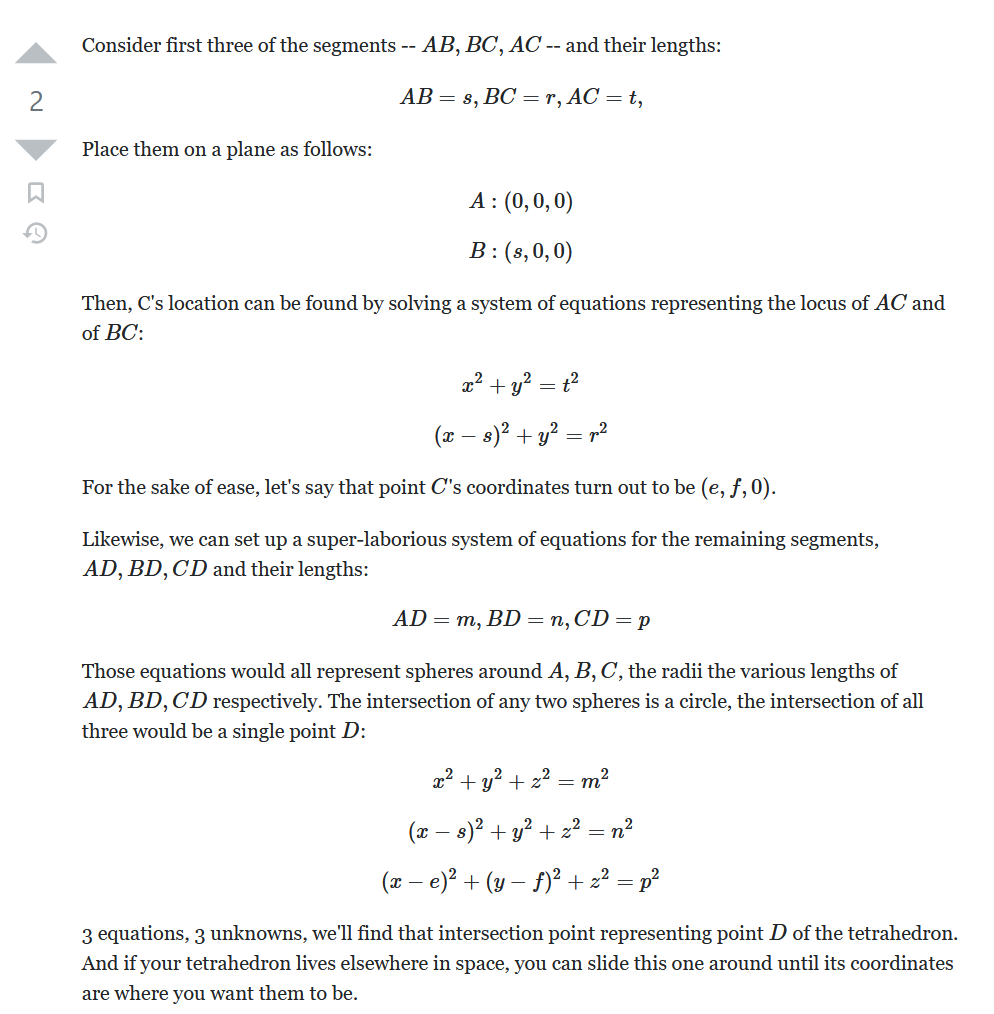

https://www.eng.uc.edu/~beaucag/Classes/Properties/OptionalProjects/CoordinateTransformationCode/Rotate%20about%20an%20arbitrary%20axis%20(3%20dimensions).html

In [ ]:
#http://wiki.gis.com/wiki/index.php/Trilateration



<AxesSubplot:ylabel='Count'>

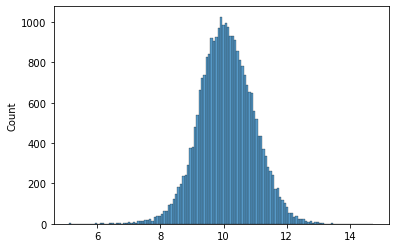

In [34]:
mp_01 = get_midpoint(X,helices_desired=[0,1])
mp_02 = get_midpoint(X,helices_desired=[2,3])
d= np.linalg.norm(mp_02-mp_01,axis=1)
sns.histplot(d)

In [39]:
bi([0,1])

array([ 0,  1,  2,  7,  8, 13], dtype=int64)

In [38]:


def bi_single(ep_index,num_helices=4, singlePoint=-1):
    
    #prep indices for distance map
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    il1 = np.tril_indices(num_ep, 1)
    tot_ind = []
    
    if singlePoint == -1:
        for x in permutations(ep_index,2):
            new_ind = np.intersect1d(mat_ind[x[0]], mat_ind.T[x[1]])
            tot_ind.extend(new_ind)
    else: 
        for x in (ep_index):
            new_ind = np.intersect1d(mat_ind[x], mat_ind.T[singlePoint])
            tot_ind.extend(new_ind)
    
    upperInd = np.intersect1d(tot_ind,mat_ind[iu1])
    lowerInd = np.intersect1d(tot_ind,mat_ind[il1])
    
    if len(upperInd)>len(lowerInd):
        return upperInd
    else:
        return lowerInd

In [ ]:
#save
#assemble conversions 
#converts output from generator back to real distances
dMin_all = tf.convert_to_tensor(brec.mm.data_min_, dtype=tf.float32)
mScale_all = tf.convert_to_tensor(brec.mm.scale_, dtype = tf.float32)
mMin = tf.convert_to_tensor(-1, dtype = tf.float32)

#index just the distances we need for calculation
dMin = tf.gather(dMin_all,dindex,axis=0)
mScale = tf.gather(mScale_all,dindex,axis=0)

#indexes we need to determine the +/- z value of the new points
pindex = point_dindex([5,6,7], ref=[4], num_helices = 4)
dMin_nwp = tf.gather(dMin_all,pindex,axis=0)
mScale_nwp = tf.gather(mScale_all,pindex,axis=0)